In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import math

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from yellowbrick.cluster import KElbowVisualizer

In [2]:
# assign path
path, dirs, files = next(os.walk("data/daily_dataset/"))
file_count = len(files)
df_list = []

#limitar dados
file_count = 20

# append datasets to the list 
for i in tqdm(range(file_count)):
    temp_df = pd.read_csv("data/daily_dataset/"+files[i], low_memory=False)
    df_list.append(temp_df)
    
df = pd.concat(df_list)

#read weather file
df_weather = pd.read_csv("data/weather_daily_darksky.csv", low_memory=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.61it/s]


In [3]:
#Remover Nulls
print(df.isna().sum())
df = df.dropna()

LCLid               0
day                 0
energy_median       7
energy_mean         7
energy_max          7
energy_count        0
energy_std       2111
energy_sum          7
energy_min          7
dtype: int64


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611858 entries, 0 to 31808
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LCLid          611858 non-null  object 
 1   day            611858 non-null  object 
 2   energy_median  611858 non-null  float64
 3   energy_mean    611858 non-null  float64
 4   energy_max     611858 non-null  float64
 5   energy_count   611858 non-null  int64  
 6   energy_std     611858 non-null  float64
 7   energy_sum     611858 non-null  float64
 8   energy_min     611858 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 46.7+ MB
None


In [5]:
df = df.drop(df.columns[[2, 3, 6]], axis=1)

In [6]:
# check the timestamp format and frequence
df.columns = ['house', 'day', 'max', 'count', 'value', 'min']
print(df)

           house         day    max  count   value    min
0      MAC000116  2011-12-14  2.156     25  21.846  0.385
1      MAC000116  2011-12-15  1.545     48  32.334  0.251
2      MAC000116  2011-12-16  2.343     48  33.458  0.268
3      MAC000116  2011-12-17  1.690     47  39.978  0.251
4      MAC000116  2011-12-18  2.588     48  40.663  0.199
...          ...         ...    ...    ...     ...    ...
31804  MAC004893  2013-02-27  1.036     48   5.199  0.023
31805  MAC004893  2013-02-28  0.585     48   7.329  0.012
31806  MAC004893  2013-03-01  0.798     48   7.325  0.000
31807  MAC004893  2013-03-02  0.493     48   6.067  0.042
31808  MAC004893  2013-03-03  0.766     48   5.821  0.040

[611858 rows x 6 columns]


In [7]:
# change the type of time column
df['day'] = pd.to_datetime(df['day'])

In [8]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['day'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [9]:
# time with int to plot easily
df['day_int'] = (df['day'].astype(np.int64)/100000000000).astype(np.int64)

In [10]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']

a = df.loc[df['categories'] == 0] # WeekEnd
b = df.loc[df['categories'] == 1] # WeekDay
#print(a)

a = a.groupby(['house', pd.Grouper(key='day', freq='W-MON')])['value'].sum().reset_index().sort_values(['house', 'day'])
b = b.groupby(['house', pd.Grouper(key='day', freq='W-MON')])['value'].sum().reset_index().sort_values(['house', 'day'])
#print(a)

a = a.groupby(['day'])['value'].mean().reset_index().sort_values('day')
b = b.groupby(['day'])['value'].mean().reset_index().sort_values('day')
b = b[:-1]

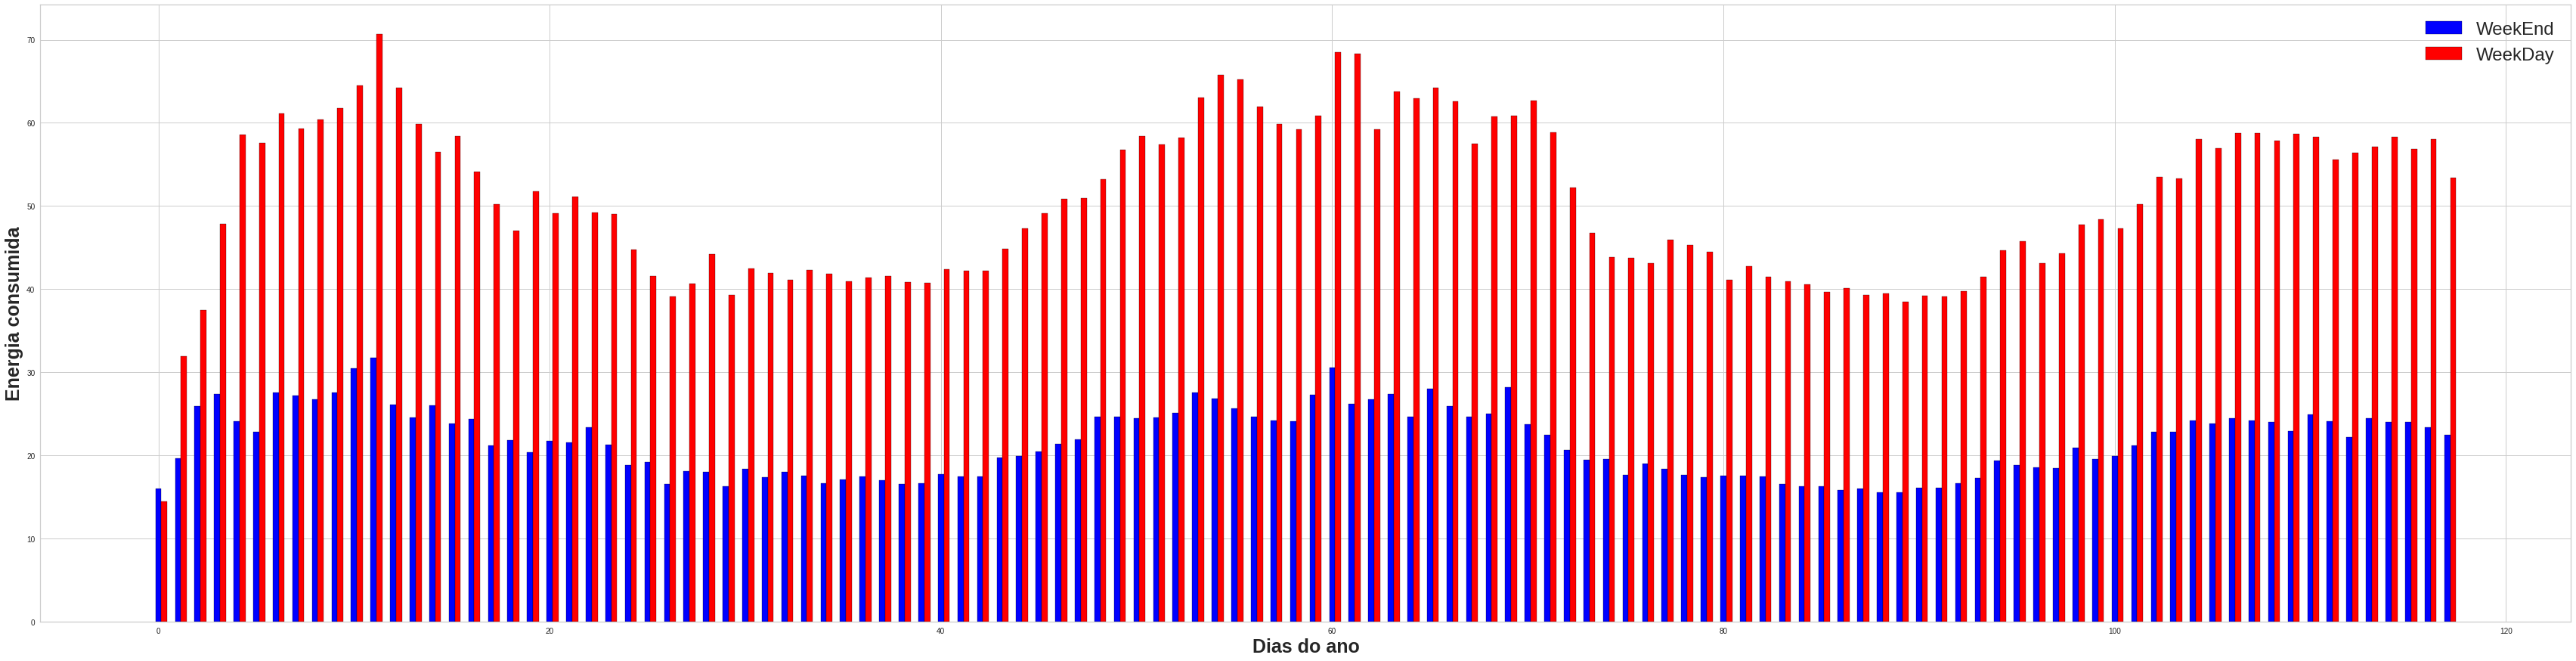

In [11]:
# set width of bar
barWidth = 0.30
fig = plt.subplots(figsize =(60, 15))

label=['WeekEnd', 'WeekDay Day']
 
# Set position of bar on X axis
br1 = np.arange(len(a))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, a['value'], color ='blue', width = barWidth,
        edgecolor ='black', label ='WeekEnd')

plt.bar(br2, b['value'], color ='red', width = barWidth,
        edgecolor ='black', label ='WeekDay')
 
# Adding Xticks
plt.xlabel('Dias do ano', fontweight ='bold', fontsize = 25)
plt.ylabel('Energia consumida', fontweight ='bold', fontsize = 25)
#plt.xticks([r + barWidth for r in range(len(a))],
#        weeks)
 
plt.legend(loc='upper right', prop={'size': 24})
plt.show()
#lux mais cara durante o dia
#grafico preço e gasto depois

In [12]:
#spring starts September 1 and ends November 30; | 9 10 11
#summer starts December 1 and ends February 28 (February 29 in a Leap Year); | 12 1 2
#fall (autumn) starts March 1 and ends May 31; | and 3 4 5
#winter starts June 1 and ends August 31; | 6 7 8

# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['MonthOfTheYear'] = df['day'].dt.month

#df['Season'] = (df['MonthOfTheYear'] < 3).astype(int)
print(df.sort_values('day'))

           house        day    max  count   value    min  DayOfTheWeek  \
2448   MAC000157 2011-11-23  0.544     21   7.408  0.160             2   
1619   MAC000151 2011-11-23  0.189     26   3.273  0.025             2   
1615   MAC000168 2011-11-24  0.178     21   1.756  0.054             3   
2443   MAC000169 2011-11-24  0.811     21   6.047  0.077             3   
4594   MAC000158 2011-11-24  0.802     30   3.181  0.000             3   
...          ...        ...    ...    ...     ...    ...           ...   
2168   MAC000062 2014-02-27  2.543     48  14.616  0.115             3   
25412  MAC003866 2014-02-27  0.200     48   4.213  0.019             3   
26339  MAC004479 2014-02-27  0.913     48   9.521  0.057             3   
3598   MAC000193 2014-02-27  2.842     48  17.264  0.009             3   
12336  MAC001411 2014-02-27  0.437     48   7.992  0.084             3   

       WeekDay   day_int  categories  MonthOfTheYear  
2448         1  13220064           1              11  
1

In [13]:
df_weather['temperatureMaxTime'] = df_weather['temperatureMaxTime'].astype('datetime64')
df_weather = df_weather[['temperatureMax', 'temperatureMaxTime']]

print(df.info())
print(df['house'].value_counts())

#df = df.merge(df_weather, left_on='day', right_on='temperatureMaxTime')
#df = df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611858 entries, 0 to 31808
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   house           611858 non-null  object        
 1   day             611858 non-null  datetime64[ns]
 2   max             611858 non-null  float64       
 3   count           611858 non-null  int64         
 4   value           611858 non-null  float64       
 5   min             611858 non-null  float64       
 6   DayOfTheWeek    611858 non-null  int64         
 7   WeekDay         611858 non-null  int64         
 8   day_int         611858 non-null  int64         
 9   categories      611858 non-null  int64         
 10  MonthOfTheYear  611858 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(1)
memory usage: 56.0+ MB
None
MAC000151    828
MAC000157    828
MAC000158    827
MAC000165    827
MAC000168    827
            ... 
MAC001229   

In [14]:
"""
fig = plt.subplots(figsize =(10, 6))
plt.plot(df['value'], df['temperatureMax'])
plt.show()
#mais frio mais energia se gasta
print(df['house'].value_counts())
"""

"\nfig = plt.subplots(figsize =(10, 6))\nplt.plot(df['value'], df['temperatureMax'])\nplt.show()\n#mais frio mais energia se gasta\nprint(df['house'].value_counts())\n"

In [15]:
# Remover casas com poucas contagens
l = df['house'].value_counts() > 650
df = df[df['house'].isin(l[l].index)]

houses = list(df.groupby('house'))

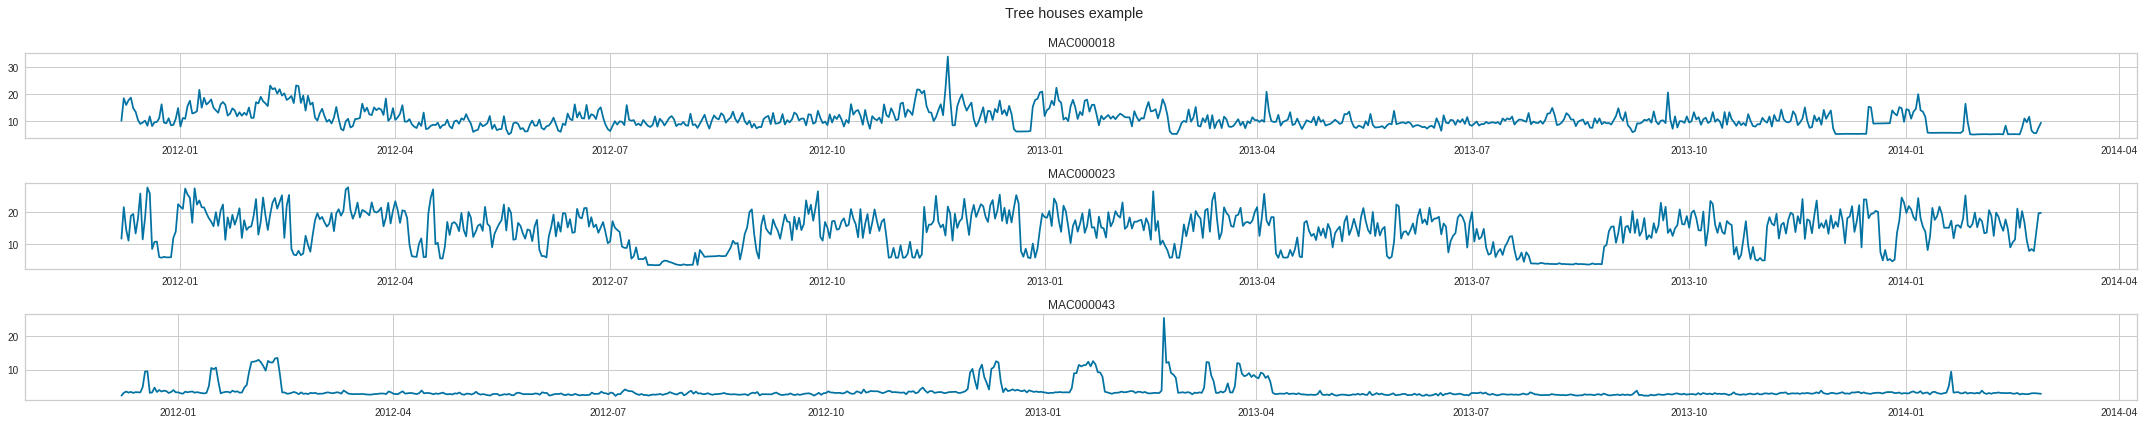

In [16]:
# plot the data

fig, (ex1, ex2, ex3) = plt.subplots(3, figsize =(30, 6))
fig.suptitle('Tree houses example')
ex1.set_title(houses[0][0])
ex1.plot(houses[0][1]['day'], houses[0][1]['value'])

ex2.set_title(houses[1][0])
ex2.plot(houses[1][1]['day'], houses[1][1]['value'])

ex3.set_title(houses[2][0])
ex3.plot(houses[2][1]['day'], houses[2][1]['value'])

fig.tight_layout()
plt.show()


In [17]:
data = df[['value', 'day_int', 'WeekDay', 'MonthOfTheYear']] #usar season e não month of the year
print(data.isna().sum())

value             0
day_int           0
WeekDay           0
MonthOfTheYear    0
dtype: int64


In [18]:
# train isolation forest 
model =  IsolationForest(contamination = 0.005)
model.fit(data.to_numpy())
# add the data to the main 

df['anomaly_forest'] = pd.Series(model.predict(data.to_numpy()))
df['anomaly_forest'] = df['anomaly_forest'].map( {1: 0, -1: 1})
print(df['anomaly_forest'].value_counts())

0    333466
1      1601
Name: anomaly_forest, dtype: int64


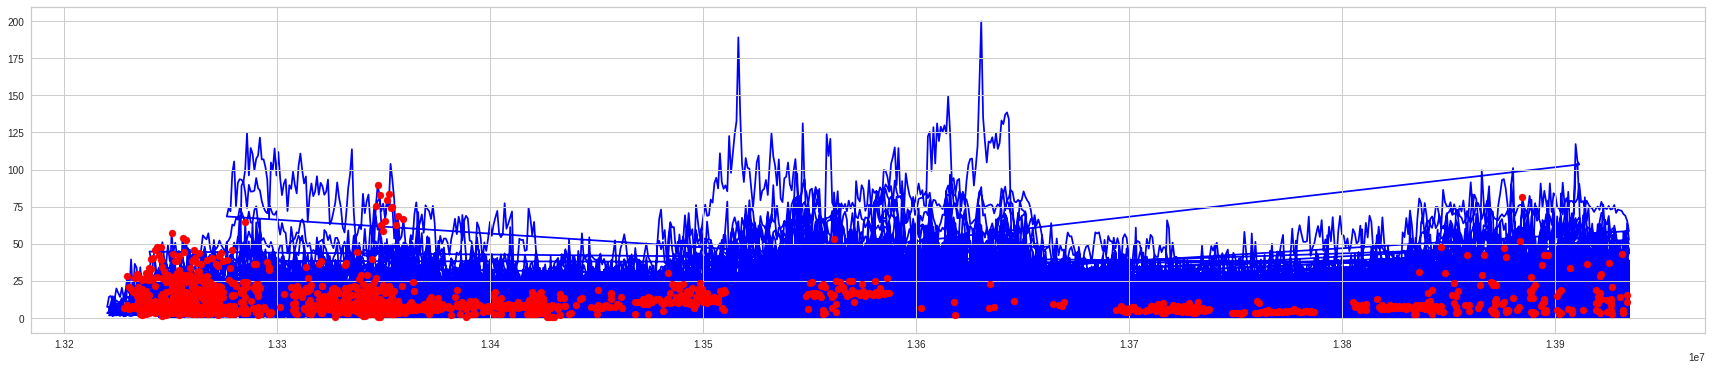

In [19]:
fig, ax = plt.subplots(figsize =(30, 6))

a = df.loc[df['anomaly_forest'] == 1, ['day_int', 'value']] #anomaly

ax.plot(df['day_int'], df['value'], color='blue', zorder=0)
ax.scatter(a['day_int'],a['value'], color='red', zorder=5)
plt.show()

In [20]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.005)
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomalySVM'] = pd.Series(model.predict(data))
df['anomalySVM'] = df['anomalySVM'].map( {1: 0, -1: 1} )
print(df['anomalySVM'].value_counts())

0    332994
1      2073
Name: anomalySVM, dtype: int64


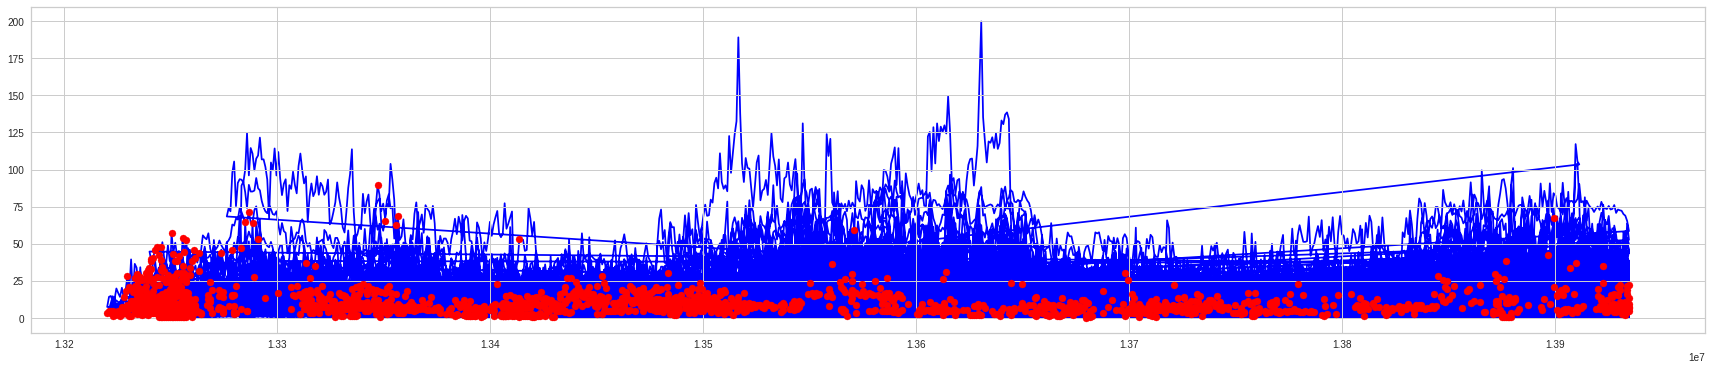

In [21]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize =(30, 6))

a = df.loc[df['anomalySVM'] == 1, ['day_int', 'value']] #anomaly

ax.plot(df['day_int'], df['value'], color='blue', zorder=0)
ax.scatter(a['day_int'],a['value'], color='red', zorder=5)
plt.show()

In [22]:
"""
# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data[0:-prediction_time-testdatacut].values()
y_train = data[prediction_time:-testdatacut  ][0].values()

# test data
x_test = data[0-testdatacut:-prediction_time].values()
y_test = data[prediction_time-testdatacut:  ][0].values()
"""

'\n# important parameters and train/test size\nprediction_time = 1 \ntestdatasize = 1000\nunroll_length = 50\ntestdatacut = testdatasize + unroll_length  + 1\n\n#train data\nx_train = data[0:-prediction_time-testdatacut].values()\ny_train = data[prediction_time:-testdatacut  ][0].values()\n\n# test data\nx_test = data[0-testdatacut:-prediction_time].values()\ny_test = data[prediction_time-testdatacut:  ][0].values()\n'

In [23]:
"""
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train

.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)
"""

'\n#unroll: create sequence of 50 previous data points for each data points\ndef unroll(data,sequence_length=24):\n    result = []\n    for index in range(len(data) - sequence_length):\n        result.append(data[index: index + sequence_length])\n    return np.asarray(result)\n\n# adapt the datasets for the sequence data shape\nx_train = unroll(x_train,unroll_length)\nx_test  = unroll(x_test,unroll_length)\ny_train = y_train[-x_train.shape[0]:]\ny_test  = y_test[-x_test.shape[0]:]\n\n# see the shape\nprint("x_train", x_train.shape)\nprint("y_train", y_train\n\n.shape)\nprint("x_test", x_test.shape)\nprint("y_test", y_test.shape)\n'